# 1 The objective of this notebook is to analyze the data from the dataset and set up a reference metric with a baseline model

## Data description

Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

In [198]:
#---------Importing libraries---------#

#---Data analysis---#
import pandas as pd
import numpy as np


#---Data visualization---#
import matplotlib.pyplot as plt
import seaborn as sns

#---Data preprocessing---#
from sklearn.preprocessing import StandardScaler

#---utils---#
import os

#ignore warnings
import warnings
warnings.filterwarnings('ignore')


## Step 1: Data Loading and Inspection

 - Load the dataset into a pandas DataFrame.
- Check the dimensions of the dataset (number of rows and columns).
- Examine the first few rows of the dataset to get an initial understanding of the data.
- Check for any missing values in the dataset.

In [199]:
df = pd.read_csv('../data/raw/term-deposit-marketing-2020.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


We can see that  the dataset have none missing values, and a lot of datapoints, 40k.
Also, There is features as objects, that could be all into the category data type.
We will first change the data type of the features that are objects, and then we will see the distribution of the data.
For this, we want to know the number of unique features in each column to decide how we are going to categorize the object columns.

## Step 2: Data Cleaning and Preprocessing

 - Handle missing values, if any, by either imputing them or removing rows/columns with missing values, depending on the situation.
- Convert categorical variables into appropriate data types (e.g., convert 'month' and 'contact' to categorical data type).
- Encode binary categorical variables ('default', 'housing', 'loan', and 'y') into numeric format (0 and 1) for modeling purposes.

In [201]:
#checking unique values in each column when the column type is object


for col in df.columns:
    if df[col].dtype == 'object':
        print(col, df[col].nunique())

job 12
marital 3
education 4
default 2
housing 2
loan 2
contact 3
month 11
y 2


In [202]:
#converting month into datetime, when the data is the name of the month only
df['month'] = pd.to_datetime(df['month'], format='%b').dt.month

#results
df['month'].dtypes

dtype('int64')

In [203]:
df['month'].head()

0    5
1    5
2    5
3    5
4    5
Name: month, dtype: int64

In [204]:
#storing binary and then categorical data
#binary data
binary_features = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes == 'object' and col != 'y']
# categorical data
categorical_features = [col for col in df.columns if  df[col].nunique() > 2 and df[col].dtypes == 'object']

#showing results
print('Binary features: ', binary_features)
print('Categorical features: ', categorical_features)

Binary features:  ['default', 'housing', 'loan']
Categorical features:  ['job', 'marital', 'education', 'contact']


In [205]:
#values of the columns
print('Binary features\n')
for col in binary_features:
    print('Column_binary: ', col)
    print('Unique values: ', df[col].unique())
    print('Number of unique values: ', len(df[col].unique()))

print('\nCategorical  features\n')
for col in categorical_features:
    print('Column_categorical: ', col)
    print('Unique values: ', df[col].unique())
    print('Number of unique values: ', len(df[col].unique()))
    print('\n')

Binary features

Column_binary:  default
Unique values:  ['no' 'yes']
Number of unique values:  2
Column_binary:  housing
Unique values:  ['yes' 'no']
Number of unique values:  2
Column_binary:  loan
Unique values:  ['no' 'yes']
Number of unique values:  2

Categorical  features

Column_categorical:  job
Unique values:  ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
Number of unique values:  12


Column_categorical:  marital
Unique values:  ['married' 'single' 'divorced']
Number of unique values:  3


Column_categorical:  education
Unique values:  ['tertiary' 'secondary' 'unknown' 'primary']
Number of unique values:  4


Column_categorical:  contact
Unique values:  ['unknown' 'cellular' 'telephone']
Number of unique values:  3




In [206]:
#converting data to the right dtype. Also, age will be converted to a categorical variable

# defing the funtion to convert the data to the right dtype
def convert_features(df: object):
    """
    Converts the data to the right dtype
    """
    binary_features = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtypes == 'object' ]
    categorical_features = [col for col in df.columns if df[col].nunique() > 2 and df[col].dtypes == 'object' and col != 'y']
    

    # converting binary features to 0 and 1
    df[binary_features] = df[binary_features].replace({'no': 0, 'yes': 1})

    # converting categorical features to dummy variables
    df[categorical_features] = df[categorical_features].astype('category')


   
    

    return df
    


In [207]:
#converting the data into a dataframe with desired dtypes

convert_features(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        40000 non-null  int64   
 1   job        40000 non-null  category
 2   marital    40000 non-null  category
 3   education  40000 non-null  category
 4   default    40000 non-null  int64   
 5   balance    40000 non-null  int64   
 6   housing    40000 non-null  int64   
 7   loan       40000 non-null  int64   
 8   contact    40000 non-null  category
 9   day        40000 non-null  int64   
 10  month      40000 non-null  int64   
 11  duration   40000 non-null  int64   
 12  campaign   40000 non-null  int64   
 13  y          40000 non-null  int64   
dtypes: category(4), int64(10)
memory usage: 3.2 MB


In [208]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,0


## Step 3: Data Exploration and Visualization

- Explore the distribution of the target variable 'y' (term deposit subscription) to understand the class balance (whether it's imbalanced or not).
- Analyze the distribution of each numerical feature (e.g., 'age', 'balance', 'day', 'duration', 'campaign') using histograms and other visualizations.
- Visualize the relationships between the target variable and other numerical features using box plots, scatter plots, or violin plots, as well as correlation matrix plots.
- Examine the distribution of categorical features ('job', 'marital', 'education', 'month') using bar plots or count plots.



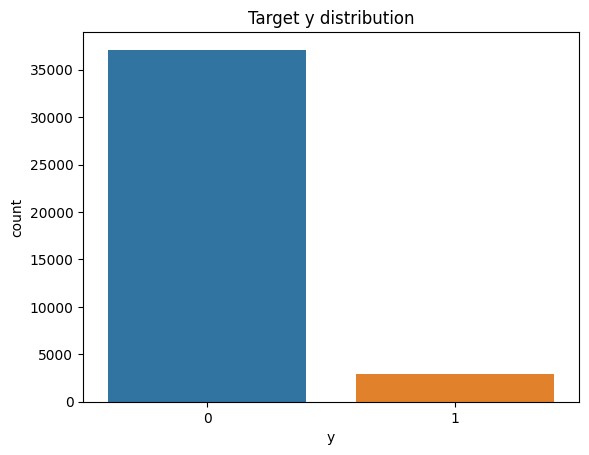

In [209]:
# checking for data target y imbalance

sns.countplot(x='y', data=df)
plt.title('Target y distribution')
plt.show()

This data is very unbalanced, and we will need to take this into account when we train our model. We will use the SMOTE algorithm to oversample the minority class. This will help us to avoid overfitting and improve the accuracy of our model.

## Step 4: Feature Engineering

- Create new features if necessary. For example, you could create a binary feature indicating whether a customer was contacted on a weekday or weekend based on the 'day' column, as well as categoryzing the age feature

- Explore feature interactions and transformations that might be useful for modeling.

In [210]:
# checking for age range
df['age'].describe()

count    40000.000000
mean        40.544600
std          9.641776
min         19.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [212]:
# converting age to categorical variable
df['age'] = pd.cut(df['age'], bins=[18, 30, 60, 100], labels=['adult', 'mid-aged', 'elderly'])


## Step 5: Baseline Model

- Select a simple machine learning model as a baseline, such as Logistic Regression or Decision Tree Classifier.
- Split the data into training and testing sets.
- Train the baseline model using the training data.
- Evaluate the model's performance on the testing data using appropriate evaluation metrics (e.g., accuracy, precision, recall, F1-score, ROC-AUC).

## Step 6: Interpretation and Analysis

- Interpret the baseline model's results and identify areas of improvement.
- Analyze which features have the most significant impact on the target variable.

## Step 7: Future Steps and Iteration

- Based on the insights gained from EDA and the baseline model, plan the next steps in the data science project, which may include more advanced modeling techniques, feature selection, hyperparameter tuning, and model evaluation.
